# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

# Python Version
Python 3.6.6 :: Anaconda custom (64-bit).

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# To be able to convert string to list
import ast

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import time

from sklearn.ensemble import RandomForestClassifier

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
# The following code is helping us replace missing or unknow values, very dirty!
feat_info["missing_or_unknown"] = feat_info["missing_or_unknown"].str.replace("X","'X'")
feat_info["missing_or_unknown"] = feat_info["missing_or_unknown"].str.replace("'X''X'","'XX'")

In [3]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    lst_mu = ast.literal_eval(row['missing_or_unknown'])
    if lst_mu :
        azdias[row['attribute']] = azdias[row['attribute']].replace(lst_mu, np.NaN)

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

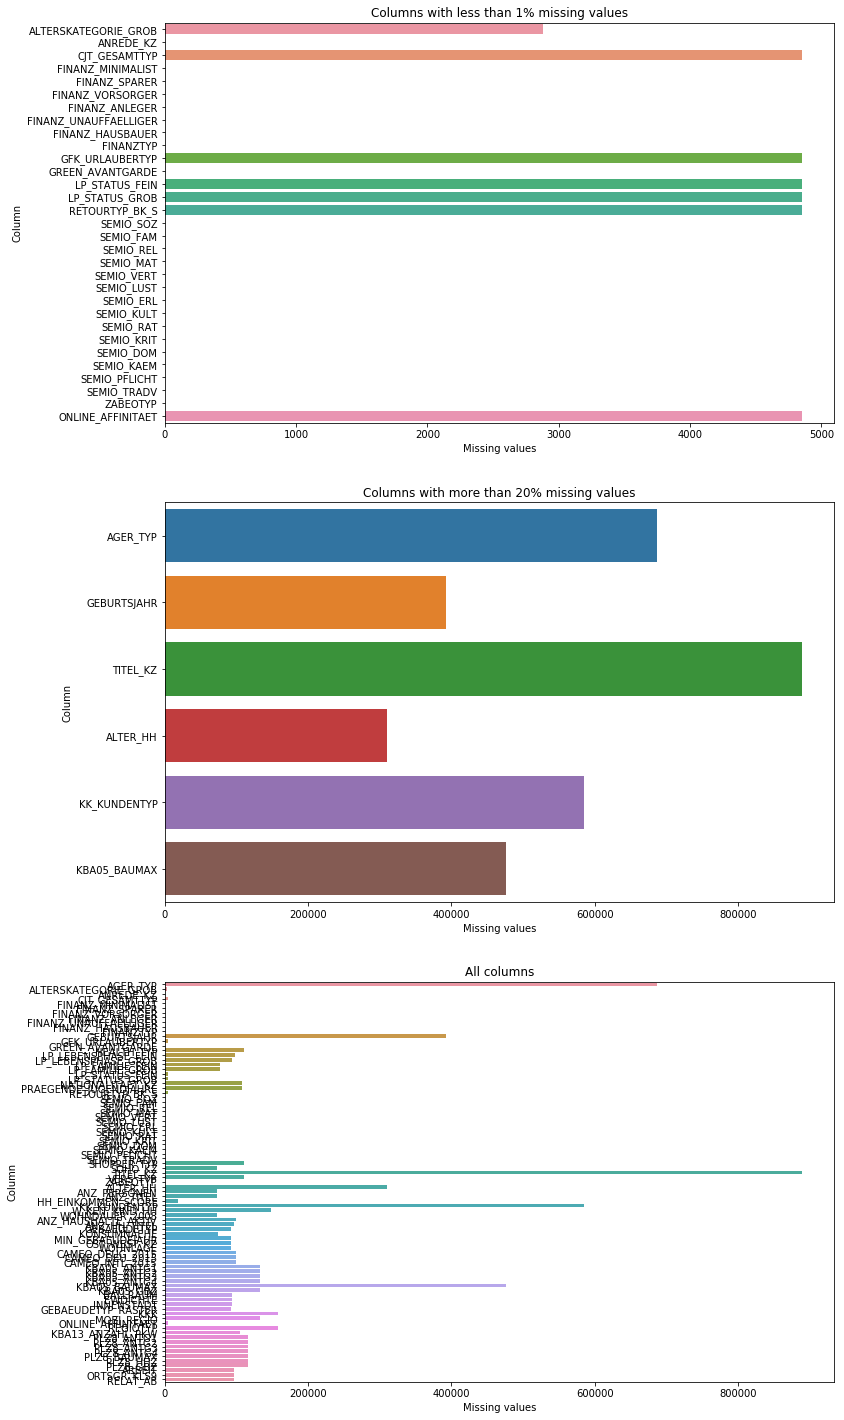

In [8]:
# Investigate patterns in the amount of missing data in each column.
# This is a series object
s  = azdias.isnull().sum(axis=0)
# Convert this to dataframe to feed it to seaborn
df = pd.DataFrame({'Column':s.index, 'Missing values':s.values})

threshold_max = 0.01
threshold_min = 0.2

# Create two plots, one to display all column names that have 
fig = plt.figure(figsize=(12,25))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title("Columns with less than {:0.0f}% missing values".format(threshold_max * 100))
ax2.set_title("Columns with more than {:0.0f}% missing values".format(threshold_min * 100))
ax3.set_title("All columns")

sns.barplot(x='Missing values', y='Column', data=df[df['Missing values'] <= azdias.shape[0] * 0.01], ax=ax1)

sns.barplot(x='Missing values', y='Column', data=df[df['Missing values'] >= azdias.shape[0] * threshold_min] , ax=ax2)

sns.barplot(x='Missing values', y='Column', data=df, ax=ax3)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C0CCC18>]],
      dtype=object)

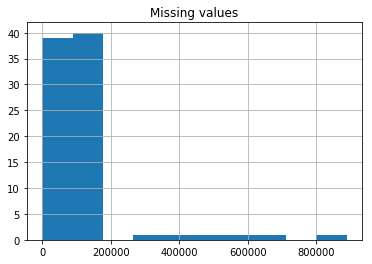

In [9]:
# Make a histogram of number of missing columns
df.hist()

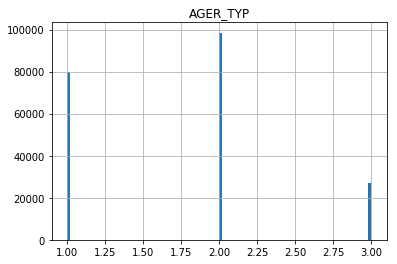

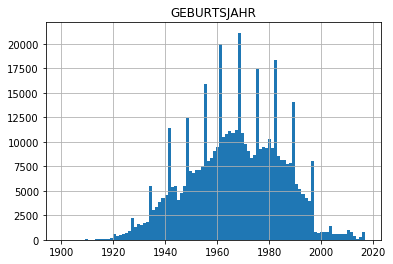

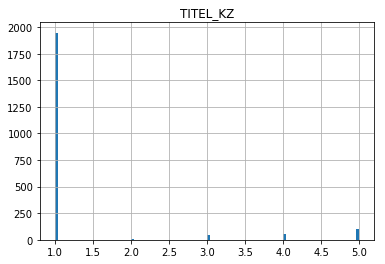

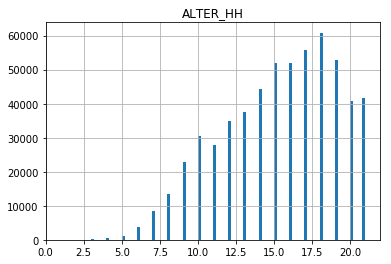

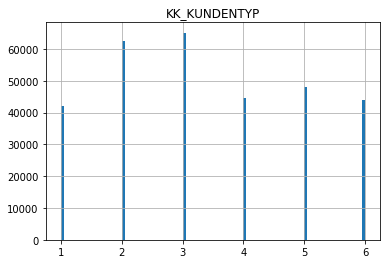

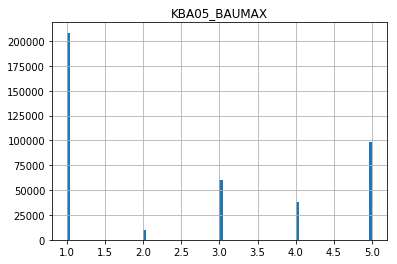

In [10]:
# Of the outlier columns, visualize the distributions of these columns
columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

for x in azdias[columns].columns:
    azdias.hist(column = x, bins = 100)

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Just followed the instructions and removed the columns that had significant more missing data than most columns, while 
# my own preferences would be to impute missing data
if 'AGER_TYP' in azdias.columns:
    azdias.drop(columns, inplace=True, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There is definitely a pattern in the amount of missing data. There are a lot of columns that have the exact same number of missing values, most likely these are the same rows. This will be investigated below. 
Looking at the histogram plot and at the 2nd and 3th subplot you can see there are 6 outliers, namely:

AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX

I found a [resource](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4) that stated that you should only consider removing a column if more than 60% percentage of the data is missing. This is only true for AGER_TYP, TITEL_KZ and KK_KUNDENTYP. For the other columns (GEBURTSJAHR, ALTER_HH, KBA05_BAUMAX) it is advised to impute missing values with some clustering or other ML algorithm. Since it was the assignment to remove all columns that have significant more missing data then the rest I deleted the other columns as well.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

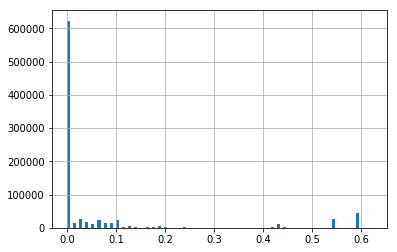

In [12]:
# How much data is missing in each row of the dataset?
azdias.isnull().mean(axis=1).hist(bins = 100)

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Based on feedback I wanted to compare more than 16 columns per row missing, compared to less than 16 rows missing.
thresh = 16
azdias['hasNaN'] = azdias.isnull().sum(axis=1) > thresh 

In [14]:
def visualize(col, dataframe) :
    ###########################################################################################################
    # Function visualize
    # Input parameters
    #    - col          : Column name that exists in the dataframe
    #    - dataframe    : Dataframe, including a column 'hasNaN'
    #
    # Returns
    #    - plot         : Subplot with the distributions 
    #
    # Note that I did not succeed at making a subplot using seaborns catplot.. Wasted some hours on trying to 
    # make it work but still unsuccesfull. 
    ###########################################################################################################
    
    # Not exactly as suggested in the notebook, but this is the only way I got it working with percentages
    # First do group by on both hasNaN and the column that we want to display
    df_gb1 = dataframe.groupby(['hasNaN', col]).size().reset_index(name='counts')
    # Then calculate the total number of rows for each hasNaN
    df_gb2 = dataframe.groupby(['hasNaN']).size().reset_index(name='counts_total')
    # Then join the dataframes together so that we can calculate the percentage
    final_df = pd.merge(df_gb1, df_gb2, left_on = ['hasNaN'], right_on = ['hasNaN'], how = 'inner')
    # Calculate the percentage
    final_df['percentage'] = final_df['counts'] / final_df['counts_total']
    
    g = sns.catplot(col, 'percentage', "hasNaN", data=final_df, kind="bar", legend=True)
    plt.show()

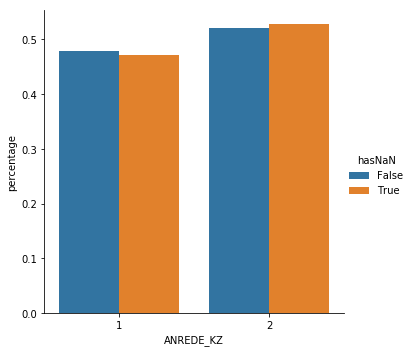

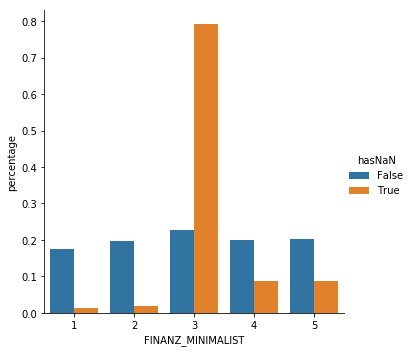

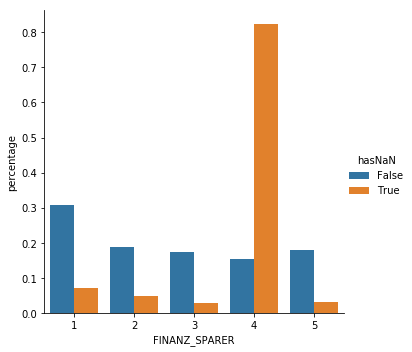

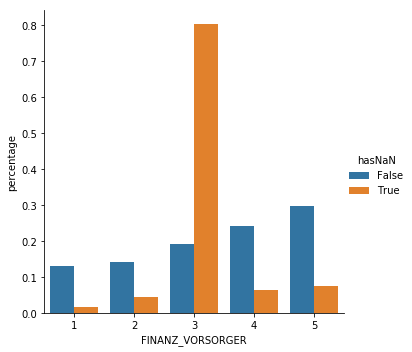

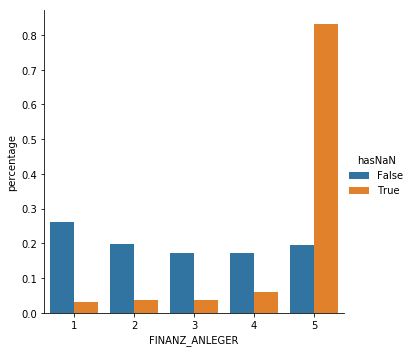

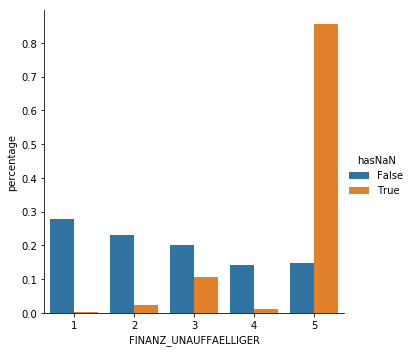

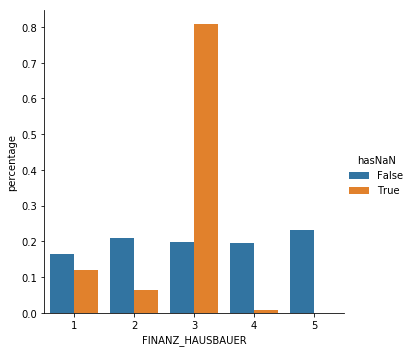

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Get a list of all the columns that don't have any missing values
no_missing_values = df[df['Missing values'] == 0]['Column'].values.tolist()
number_of_subplots = len(no_missing_values)

# Compare all columns that do not have missing values
for idx, col in enumerate(no_missing_values) :
    # Make some plots, don't have to make plots for all columns, but could be done by removing the if statement below
    if idx > 6 :
        break
    visualize(col, azdias)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at the plots below I believe the rows that have no missing data's are rather different from rows that do have missing data. This could have some meaning.

For all FINANZ_* columns you can see that for the missing rows each of these column have one outlier for one of its values. For FINANZ_MINIMALIST this is the value 3, this is someone with an average profile for low financial interest. For FINANZ_SPARER this is the value 4, this is someone with a low profile for money saving. For FINANZ_VORSAGER this is the value 3, this is someone with an average profile for being financially prepared. For FINANZ_Anleger this is the value 5, this is someone a very low profile for investing money. For FINANZ_UNAUFFAELLIGER this is also the value 5, this is someone with a very low profile for being inconspicuous in the financial domain. For FINANZ_HAUSBAUER this is the value 3, this is someone with an average profile for home ownership. 

The rows with missing data look so different from rows with no missing data that we cannot simply ignore these rows, thus we should not delete this data! However we should not forget that this might be introducing a bias!!

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
num_categorical = len(feat_info[feat_info['type']=='categorical'])
num_mixed = len(feat_info[feat_info['type']=='mixed'])
print("There are {} categorical variables and {} mixed variables in the original file".format(num_categorical, num_mixed))

There are 21 categorical variables and 7 mixed variables in the original file


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_feat = feat_info[feat_info['type']=='categorical']

# First show all unique values for each feature.
for feature in cat_feat['attribute']:
    if feature in azdias.columns:
        print(feature)
        print('-------------------')
        print(azdias[feature].unique())
        print(azdias[feature].dtypes)
        print('')

ANREDE_KZ
-------------------
[1 2]
int64

CJT_GESAMTTYP
-------------------
[ 2.  5.  3.  4.  1.  6. nan]
float64

FINANZTYP
-------------------
[4 1 6 5 2 3]
int64

GFK_URLAUBERTYP
-------------------
[10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
float64

GREEN_AVANTGARDE
-------------------
[0 1]
int64

LP_FAMILIE_FEIN
-------------------
[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
float64

LP_FAMILIE_GROB
-------------------
[ 2.  3.  1. nan  5.  4.]
float64

LP_STATUS_FEIN
-------------------
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]
float64

LP_STATUS_GROB
-------------------
[ 1.  2.  4.  5.  3. nan]
float64

NATIONALITAET_KZ
-------------------
[nan  1.  3.  2.]
float64

SHOPPER_TYP
-------------------
[nan  3.  2.  1.  0.]
float64

SOHO_KZ
-------------------
[nan  1.  0.]
float64

VERS_TYP
-------------------
[nan  2.  1.]
float64

ZABEOTYP
-------------------
[3 5 4 1 6 2]
int64

GEBAEUDETYP
-------------------
[nan  8.  1.  3.  2.  6.  4.  5.]
float64

OST

In [18]:
# create list with all existing categorical columns in azdias that are multi-level categorical
cat_attr = list()
for cat in cat_feat['attribute']:
    if cat in azdias.columns:
        if len(azdias[cat].unique()) > 2:
            cat_attr.append(cat)          

In [19]:
# To be able to hotencode all types of variables we have to cast them to string in get_dummies. Otherwise get_dummies will not
# treat it as a categorical variable.
hotencoded_df = pd.get_dummies(azdias[cat_attr].astype(str))

In [20]:
# Add all hotencoded new variables to the dataframe
df_processed = pd.concat([azdias, hotencoded_df], axis=1, ignore_index=False)
# Drop the variables that we just have encoded into new variables
for col in cat_attr:
    df_processed.drop(col, axis=1, inplace=True)

In [21]:
df_processed.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
count,888340.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,2.757217,1.522098,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,0.196612,2.190129,...,0.058838,0.037515,0.034776,0.019721,0.023049,0.031054,0.028037,0.032083,0.007158,0.111479
std,1.009951,0.499512,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,0.397437,0.755213,...,0.235322,0.190020,0.183212,0.139041,0.150060,0.173464,0.165078,0.176221,0.084299,0.314724
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Discussion 1.2.1: Re-Encode Categorical Features

I decided that for categorical values that have more than two options, NaN included as a option, these should all be hotencoded. Could not find any reason why to drop these columns from the analysis. Later on we will do dimensionality reduction and remove unnecessary columns. So for now lets interpret as if missing data could also have some meaning.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [74]:
# Check which variables are of type mixed
cat_feat = feat_info[feat_info['type']=='mixed']

# First show all unique values for each feature.
for feature in cat_feat['attribute']:
    if feature in azdias.columns:
        print(feature)
        print('-------------------')
        print(azdias[feature].unique())
        print(azdias[feature].dtypes)
        print('')

LP_LEBENSPHASE_FEIN
-------------------
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
float64

LP_LEBENSPHASE_GROB
-------------------
[ 4.  6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  8. nan]
float64

PRAEGENDE_JUGENDJAHRE
-------------------
[ 0 14 15  8  3 10 11  5  9  6  4  2  1 12 13  7]
int64

WOHNLAGE
-------------------
[nan  4.  2.  7.  3.  5.  1.  8.  0.]
float64

CAMEO_INTL_2015
-------------------
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
object

KBA05_BAUMAX
-------------------
[nan  5.  0.  1.  2.  3.  4.]
float64

PLZ8_BAUMAX
-------------------
[nan  1.  2.  4.  5.  3.]
float64



In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Initially I thought we could simply make a variable movement. But this is not completely true because 
# we also have NaN values in this column
mainstream = {
    1 : 1,
    2 : 0,
    3 : 1,
    4 : 0,
    5 : 1,
    6 : 0,
    7 : 0,
    8 : 1,
    9 : 0,
    10: 1,
    11: 0,
    12: 1,
    13: 0,
    14: 1,
    15: 0, 
    np.nan: 0
}
avantgarde = {
    1 : 0,
    2 : 1,
    3 : 0,
    4 : 1,
    5 : 0,
    6 : 1,
    7 : 1,
    8 : 0,
    9 : 1,
    10: 0,
    11: 1,
    12: 0,
    13: 1,
    14: 0,
    15: 1, 
    np.nan: 0
}

decade = {
    1 : 40,
    2 : 40,
    3 : 50,
    4 : 50,
    5 : 60,
    6 : 60,
    7 : 60,
    8 : 70,
    9 : 70,
    10: 80,
    11: 80,
    12: 80,
    13: 80,
    14: 90,
    15: 90, 
}

In [46]:
pd.options.mode.chained_assignment = None  # default='warn'
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
temp = df_processed[['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX']]
# test = df_processed['PRAEGENDE_JUGENDJAHRE'].map(mainstream)
# temp = pd.DataFrame()
temp['PRAEGENDE_JUGENDJAHRE_M'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(mainstream).to_frame()
temp['PRAEGENDE_JUGENDJAHRE_A'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(avantgarde).to_frame()
temp['PRAEGENDE_JUGENDJAHRE_MA_nan'] = df_processed['PRAEGENDE_JUGENDJAHRE'].isnull() * 1
temp['PRAEGENDE_JUGENDJAHRE_decade'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(decade).to_frame()
temp['CAMEO_INTL_2015_wealth'] = temp['CAMEO_INTL_2015'].astype(str).replace('nan', np.nan).str[0:-1]
temp['CAMEO_INTL_2015_lifestage'] = temp['CAMEO_INTL_2015'].astype(str).replace('nan', np.nan).str[-1:]
temp

# Remove the original columns from the temporary dataframe
temp.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

# This is the list of mixed variables that are still ordinal and should be hotencoded
cols = ['PRAEGENDE_JUGENDJAHRE_decade', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_lifestage', 'WOHNLAGE', 'PLZ8_BAUMAX']
# To be able to hotencode all types of variables we have to cast them to string in get_dummies. Otherwise get_dummies will not
# treat it as a categorical variable.
hotencoded_temp = pd.get_dummies(temp[cols].astype(str))

# Add all hotencoded new variables to the dataframe
temp_processed = pd.concat([temp, hotencoded_temp], axis=1, ignore_index=False)
# Drop the variables that we just have encoded into new variables
for col in cols:
    temp_processed.drop(col, axis=1, inplace=True)
temp_processed.describe()

,PRAEGENDE_JUGENDJAHRE_M,PRAEGENDE_JUGENDJAHRE_A,PRAEGENDE_JUGENDJAHRE_MA_nan,PRAEGENDE_JUGENDJAHRE_decade_40.0,PRAEGENDE_JUGENDJAHRE_decade_50.0,PRAEGENDE_JUGENDJAHRE_decade_60.0,PRAEGENDE_JUGENDJAHRE_decade_70.0,PRAEGENDE_JUGENDJAHRE_decade_80.0,PRAEGENDE_JUGENDJAHRE_decade_90.0,PRAEGENDE_JUGENDJAHRE_decade_nan,...,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,WOHNLAGE_nan,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan
count,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,0.682022,0.196612,0.121366,0.032271,0.084879,0.130246,0.201474,0.170294,0.259469,0.121366,...,0.083420,0.189984,0.019606,0.104517,0.560523,0.079001,0.056924,0.063603,0.109213,0.130736
std,0.465691,0.397437,0.326552,0.176720,0.278702,0.336574,0.401102,0.375891,0.438343,0.326552,...,0.276517,0.392289,0.138641,0.305931,0.496324,0.269740,0.231698,0.244044,0.311907,0.337112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
# Add all new variables to a new dataframe
data = pd.concat([df_processed, temp_processed], axis=1, ignore_index=False)
# Drop the variables that we have decided to remove from the analysis
data.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

In [50]:
# Making sure that we remove all original variables from the dataframe
for feature in cat_feat['attribute']:
    if feature in data.columns:
        print("{} zit in de data dataframe".format(feature))
        data.drop(feature, axis=1, inplace=True)
    else :
        print("{} zit niet in de data dataframe".format(feature))

LP_LEBENSPHASE_FEIN zit niet in de data dataframe
LP_LEBENSPHASE_GROB zit niet in de data dataframe
PRAEGENDE_JUGENDJAHRE zit niet in de data dataframe
WOHNLAGE zit niet in de data dataframe
CAMEO_INTL_2015 zit niet in de data dataframe
KBA05_BAUMAX zit niet in de data dataframe
PLZ8_BAUMAX zit niet in de data dataframe


In [51]:
data.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,WOHNLAGE_nan,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan
count,888340.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,...,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,2.757217,1.522098,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,0.196612,2.190129,...,0.083420,0.189984,0.019606,0.104517,0.560523,0.079001,0.056924,0.063603,0.109213,0.130736
std,1.009951,0.499512,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,0.397437,0.755213,...,0.276517,0.392289,0.138641,0.305931,0.496324,0.269740,0.231698,0.244044,0.311907,0.337112
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Discussion 1.2.2: Engineer Mixed-Type Features

For PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015_wealth I created new variables. The newly created variables PRAEGENDE_JUGENDJAHRE_decade, CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_lifestage are all ordinal variables. These should be hotencoded, this has as advantage that we don't have any NaN values in the hotencoded variables.

LP_LEBENSPHASE_GROB and LP_LEBENSPHASE_FEIN contain information about income, age and household type. All this information we already have in variables like LP_FAMILIE_FEIN, ALTERSKATEGORIE_GROB, GEBURTSJAHR and FINANZ_* variables. Therefore I decided to remove these variables from the analysis. After invesegating variables WOHNLAGE and PLZ8_BAUMAX these variables looked very ordinal to me and are in fact not mixed variables. Therefore I hot encoded these variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### Step 1.2.3: Discussion
I was wondering if it would be a problem that I decided to keep all rows in step 1.1.3, even if that row contains a lot of missing data. Already performed all other engineering tasks like removing the columns that are no longer necessary, therefore removed the code fields above.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df, feature_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # First create a deep copy of the object that we want to do some modifications on, just to be sure. Not really sure 
    # if necessary
    df_orig = df.copy(deep=True)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, row in feature_info.iterrows():
        lst_mu = ast.literal_eval(row['missing_or_unknown'])
        if lst_mu :
            df_orig[row['attribute']] = df_orig[row['attribute']].replace(lst_mu, np.NaN)
    
    
    # remove selected columns and rows, ...
    # Following columns are to be removed from the dataframe
    columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_orig.drop(columns, inplace=True, axis=1)
    # select, re-encode, and engineer column values.
    
    cat_feat = feat_info[feat_info['type']=='categorical']
    
    # create list with all existing categorical columns in the original dataframe that are multi-level categorical
    cat_attr = list()
    for cat in cat_feat['attribute']:
        if cat in df_orig.columns:
            if len(df_orig[cat].unique()) > 2:
                cat_attr.append(cat)
    
    # To be able to hotencode all types of variables we have to cast them to string in get_dummies. Otherwise get_dummies will not
    # treat it as a categorical variable.
    hotencoded_df = pd.get_dummies(df_orig[cat_attr].astype(str))
    
    # Add all hotencoded new variables to the dataframe
    df_processed = pd.concat([df_orig, hotencoded_df], axis=1, ignore_index=False)
    # Drop the variables that we just have encoded into new variables
    for col in cat_attr:
        if col in df_processed.columns :
            df_processed.drop(col, axis=1, inplace=True)
    
    #First remove the mixed columns that we definately are not going to use
    df_processed.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], inplace=True, axis=1)
    
    # Check which variables are of type mixed
    mix_feat = feat_info[feat_info['type']=='mixed']
    
    mix_attr = list()
    # First show all unique values for each feature.
    for feature in mix_feat['attribute']:
        if feature in df_processed.columns:
            mix_attr.append(feature)

    
    # Create some hard coded dictionaries to map the values in the mixed variable PRAEGENDE_JUGENDJAHRE to new variables.
    mainstream = {
        1 : 1,
        2 : 0,
        3 : 1,
        4 : 0,
        5 : 1,
        6 : 0,
        7 : 0,
        8 : 1,
        9 : 0,
        10: 1,
        11: 0,
        12: 1,
        13: 0,
        14: 1,
        15: 0, 
        np.nan: 0
    }
    avantgarde = {
        1 : 0,
        2 : 1,
        3 : 0,
        4 : 1,
        5 : 0,
        6 : 1,
        7 : 1,
        8 : 0,
        9 : 1,
        10: 0,
        11: 1,
        12: 0,
        13: 1,
        14: 0,
        15: 1, 
        np.nan: 0
    }

    decade = {
        1 : 40,
        2 : 40,
        3 : 50,
        4 : 50,
        5 : 60,
        6 : 60,
        7 : 60,
        8 : 70,
        9 : 70,
        10: 80,
        11: 80,
        12: 80,
        13: 80,
        14: 90,
        15: 90, 
    }
    
    temp = df_processed[mix_attr]

    temp['PRAEGENDE_JUGENDJAHRE_M'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(mainstream).to_frame()
    temp['PRAEGENDE_JUGENDJAHRE_A'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(avantgarde).to_frame()
    temp['PRAEGENDE_JUGENDJAHRE_MA_nan'] = df_processed['PRAEGENDE_JUGENDJAHRE'].isnull() * 1
    temp['PRAEGENDE_JUGENDJAHRE_decade'] = df_processed['PRAEGENDE_JUGENDJAHRE'].map(decade).to_frame()
    temp['CAMEO_INTL_2015_wealth'] = temp['CAMEO_INTL_2015'].astype(str).replace('nan', np.nan).str[0:-1]
    temp['CAMEO_INTL_2015_lifestage'] = temp['CAMEO_INTL_2015'].astype(str).replace('nan', np.nan).str[-1:]

    # This is the list of mixed variables that are still ordinal and should be hotencoded
    cols = ['PRAEGENDE_JUGENDJAHRE_decade', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_lifestage', 'WOHNLAGE', 'PLZ8_BAUMAX']
    # Now hotencode these ordinal columns
    hotencoded_temp = pd.get_dummies(temp[cols].astype(str))

    # Add all hotencoded new variables to the dataframe
    temp_processed = pd.concat([temp, hotencoded_temp], axis=1, ignore_index=False)
    
    # Drop the variables that we just have encoded into new variables from both the temp dataframe as well as from the processed dataframe
    for col in cols:
        if col in temp_processed.columns:
            temp_processed.drop(col, axis=1, inplace=True)
    
    for feature in mix_feat['attribute']:
        if feature in temp_processed.columns:
            temp_processed.drop(feature, axis=1, inplace=True)
        if feature in df_processed.columns:
            df_processed.drop(feature, axis=1, inplace=True)
    
    # Finally concatenate these dataframes and return this shit.
    data = pd.concat([df_processed, temp_processed], axis=1, ignore_index=False)
    # Return the cleaned dataframe.
    return data
    

In [4]:
data = clean_data(azdias, feat_info)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [23]:
s  = data.isnull().sum(axis=0)
# Convert this to dataframe to feed it to seaborn
df = pd.DataFrame({'Column':s.index, 'Missing values':s.values})

# Get a list of columns that have missing values in it
null_columns = df[df['Missing values'] > 0]

# Create dictionary object with these columns, so that we can do a describe on these columns
mis_col = list()
for col in null_columns['Column']:
    mis_col.append(col)

In [22]:
data[mis_col].describe()

,ALTERSKATEGORIE_GROB,HEALTH_TYP,RETOURTYP_BK_S,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,780025.000000,886367.000000,817722.000000,817722.000000,872873.000000,743233.000000,817722.000000,791610.000000,794213.000000,...,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,2.190129,3.419630,1.727637,0.004162,4.207243,4.147141,7.908791,8.354924,0.040647,...,619.701439,2.253330,2.801858,1.595426,0.699166,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.755213,1.417741,1.155849,0.068855,1.624057,1.784211,1.923137,15.673731,0.324028,...,340.034318,0.972008,0.920309,0.986736,0.727137,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,1.000000,0.000000,3.000000,3.000000,8.000000,2.000000,0.000000,...,384.000000,1.000000,2.000000,1.000000,0.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,3.000000,1.000000,0.000000,5.000000,4.000000,9.000000,4.000000,0.000000,...,549.000000,2.000000,3.000000,2.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,3.000000,5.000000,2.000000,0.000000,6.000000,6.000000,9.000000,10.000000,0.000000,...,778.000000,3.000000,3.000000,2.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,3.000000,5.000000,45.000000,6.000000,6.000000,6.000000,9.000000,595.000000,23.000000,...,2300.000000,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,5.000000


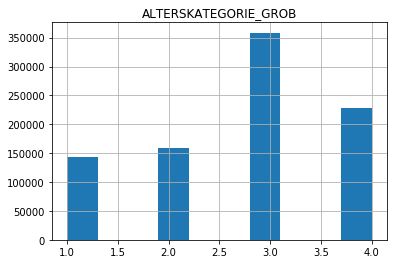

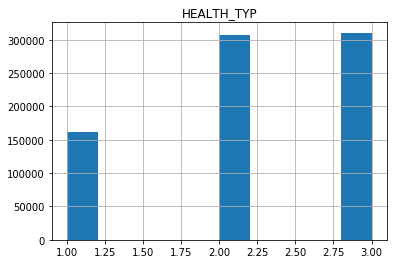

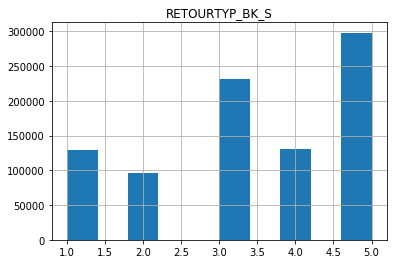

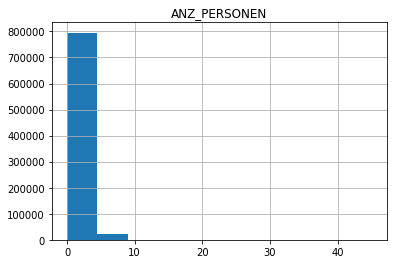

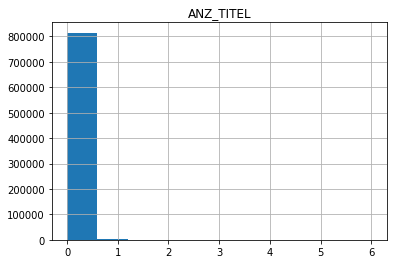

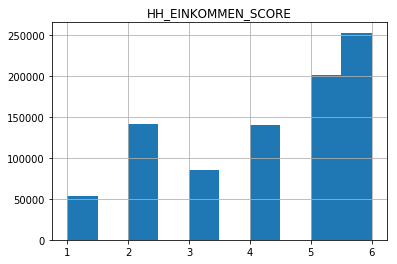

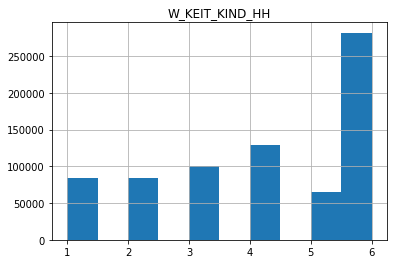

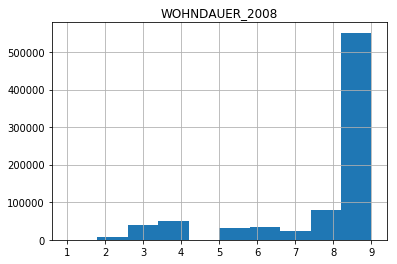

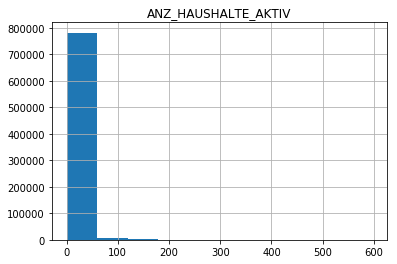

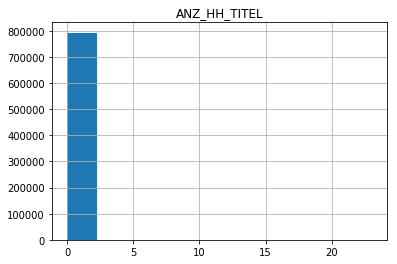

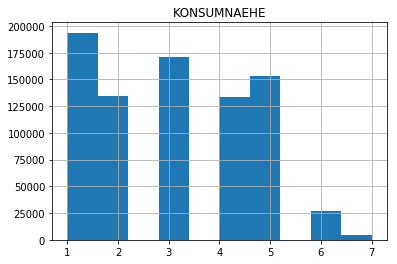

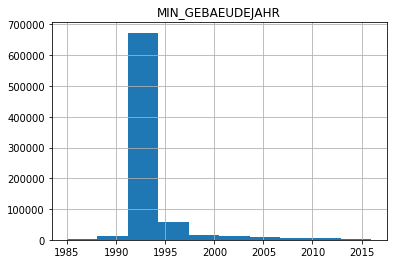

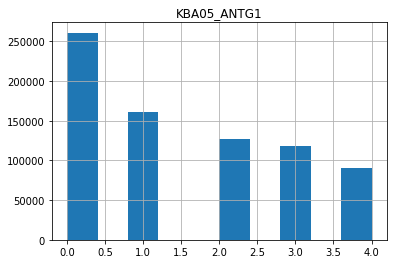

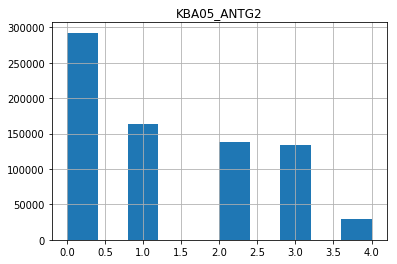

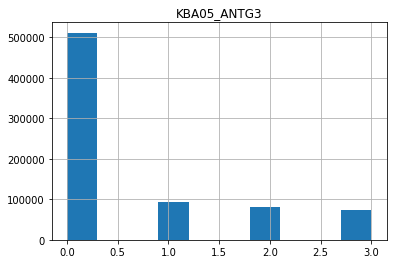

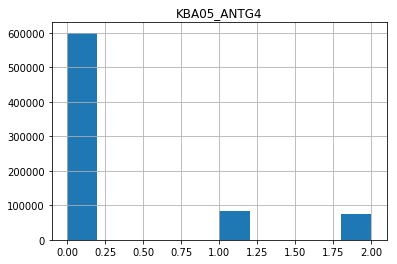

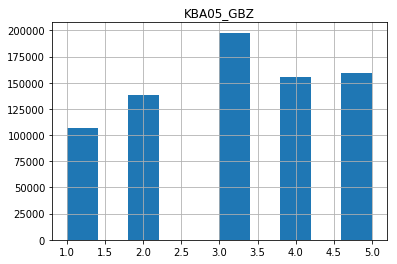

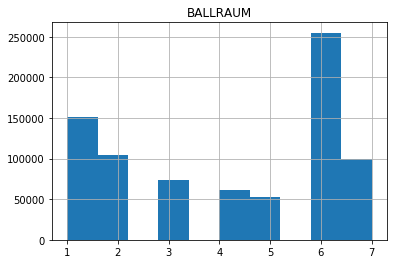

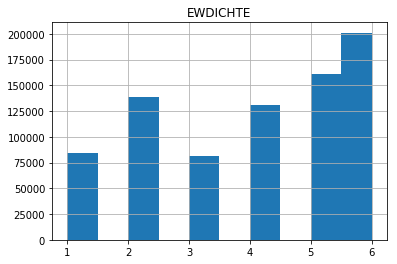

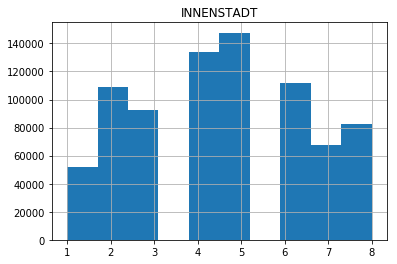

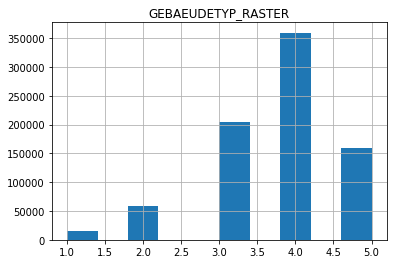

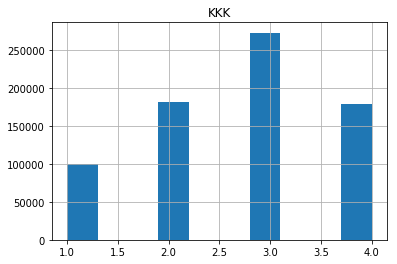

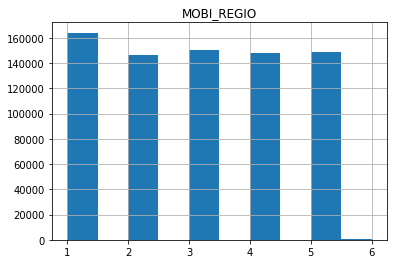

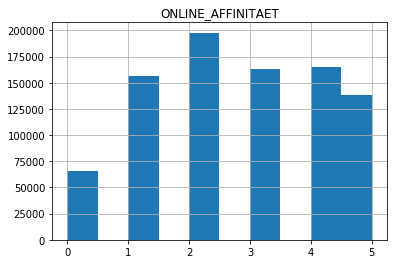

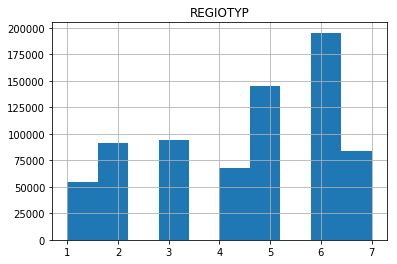

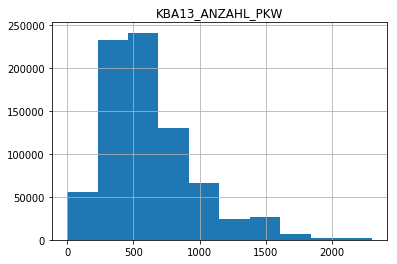

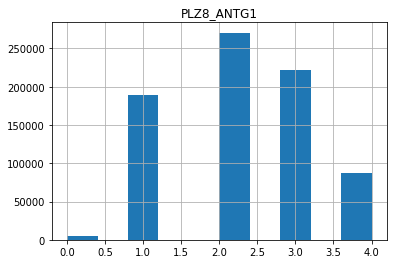

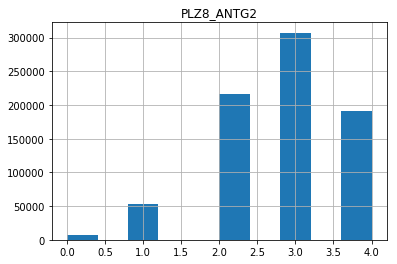

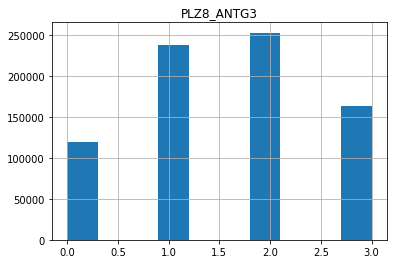

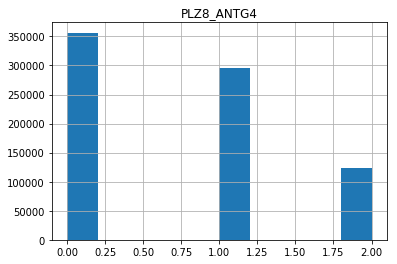

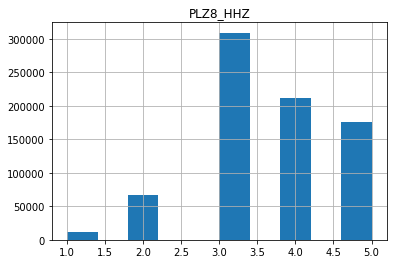

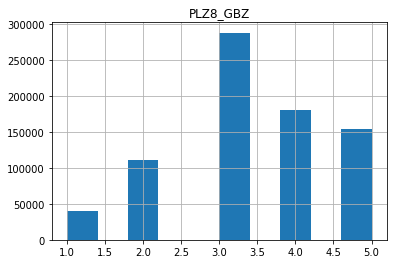

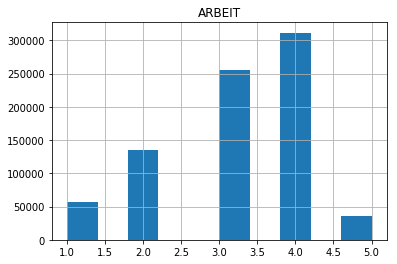

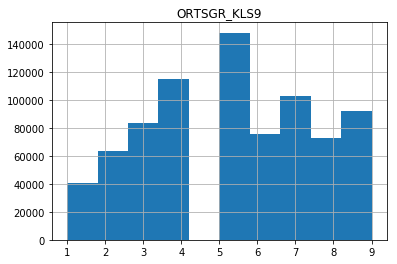

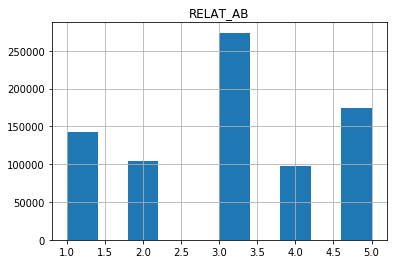

In [26]:
# Visual inspection of what the distribution of these columns look like
# Turns out that most (ordinal) variables do not follow the normal distrbution. Therefore I think imputation with median is 
# a better solutions than using the mean.
for x in data[mis_col].columns:
    data.hist(column = x)

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Create an imputer object
# Visual inspection of the columns with missing data shows that the data does not follow normal distribution, therefore
# I decided to use median strategy
imp = SimpleImputer(missing_values=np.nan, strategy='median')
# Imputer returns a numpy array, therefore we have to put it in a dataframe again
imputed_data = pd.DataFrame(imp.fit_transform(data), columns=data.columns)

In [7]:
# Apply feature scaling to the general population demographics data.
# scaled_np = StandardScaler().fit_transform(imputed_data)
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(imputed_data), columns=imputed_data.columns)

In [29]:
# Check what the data looks like
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,WOHNLAGE_nan,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,-0.234601,...,-0.301683,-0.484297,-0.141413,2.927080,-1.129351,-0.292877,-0.245683,-0.26062,-0.350147,2.578562
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,1.175204,...,-0.301683,-0.484297,-0.141413,-0.341637,0.885465,-0.292877,-0.245683,-0.26062,-0.350147,-0.387813
2,0.239980,0.956738,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,2.021423,1.175204,...,-0.301683,-0.484297,-0.141413,-0.341637,0.885465,-0.292877,-0.245683,-0.26062,-0.350147,-0.387813
3,1.231640,0.956738,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.494701,-0.234601,...,-0.301683,2.064847,-0.141413,-0.341637,0.885465,-0.292877,-0.245683,-0.26062,-0.350147,-0.387813
4,0.239980,-1.045218,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,-0.494701,1.175204,...,-0.301683,-0.484297,-0.141413,-0.341637,-1.129351,3.414400,-0.245683,-0.26062,-0.350147,-0.387813


### Discussion 2.1: Apply Feature Scaling

In step 1.1.3 I decided not remove missing data, therefore I have to do some imputation on the missing data. At first I tried [knn imputation from fancyimpute](https://pypi.org/project/fancyimpute/), but the amount of data is giving me memory issues to do these calculations (12 GB RAM). For the ordinal and numeric columns we still have missing values. I decided to check out what the distribution looks like for these columns. After visual inspection of histograms of these columns it turns out that most columns do not follow the normal distribution. Therefore I don't think it is a good idea to do mean imputation, I preferred median imputation in this scenario.

The suggested more complicated approach to temporary remove missing data and then calculate the scaling parameters might have some side effects. I think that it depends on your imputation method if this will succeed correctly. For example, if you do a mean imputation it will reduce variability in your variable, which will reduce the standard deviation of this variable. If we then scale it with the scaling parameters calculated without null values, the mean will be 0, but the standard deviation will be less than 1. Meaning that this scaled variable will have less impact on the algorithm compared to other scaled variables.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [8]:
# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.plot(ind, cumvals)
    # Plotting vertical line at half of the number of variables
    ax.axvline(x=round(num_components/2))
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

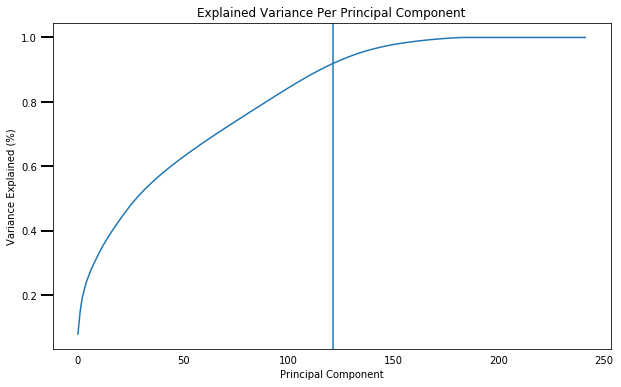

In [10]:
scree_plot(pca)

In [11]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Looking at scree plot above it looks like that if we pick half the number of variables that most variance is explained.
# This could be 121, since we used to have 242 variables.
pca = PCA(n_components=121)
x_pca = pca.fit_transform(scaled_data)

### Discussion 2.2: Perform Dimensionality Reduction

Looking at the screeplot it would make sense to keep something like half of the original variables. Adding more components would not really add more variability to the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [12]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_sort_results(data, pca, component_num) :
    components = pd.DataFrame(pca.components_, columns = scaled_data.columns)
    return components.iloc[[component_num]].sort_values(by=component_num, ascending=False, axis=1)

In [13]:
pca_sort_results(scaled_data, pca, 0)

,SOHO_KZ_nan,WOHNLAGE_nan,OST_WEST_KZ_nan,GEBAEUDETYP_nan,CAMEO_INTL_2015_lifestage_nan,CAMEO_INTL_2015_wealth_nan,CAMEO_DEU_2015_nan,CAMEO_DEUG_2015_nan,PRAEGENDE_JUGENDJAHRE_decade_nan,PRAEGENDE_JUGENDJAHRE_MA_nan,...,FINANZTYP_6,VERS_TYP_2.0,SEMIO_SOZ,PRAEGENDE_JUGENDJAHRE_M,GEBAEUDETYP_1.0,PLZ8_BAUMAX_1.0,SEMIO_VERT,OST_WEST_KZ_W,NATIONALITAET_KZ_1.0,SOHO_KZ_0.0
0,0.205756,0.205342,0.205342,0.205342,0.20158,0.20158,0.20158,0.20158,0.192016,0.192016,...,-0.065521,-0.067308,-0.071393,-0.086237,-0.088986,-0.111895,-0.112474,-0.115806,-0.143281,-0.196702


In [14]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_sort_results(scaled_data, pca, 1)

,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,ORTSGR_KLS9,CAMEO_INTL_2015_wealth_5,EWDICHTE,CAMEO_INTL_2015_lifestage_1,FINANZ_HAUSBAUER,LP_STATUS_FEIN_1.0,...,BALLRAUM,PLZ8_GBZ,INNENSTADT,KONSUMNAEHE,PLZ8_BAUMAX_1.0,FINANZ_MINIMALIST,KBA05_GBZ,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO
1,0.186777,0.179833,0.173055,0.167378,0.159681,0.158354,0.154836,0.146545,0.144137,0.134063,...,-0.103181,-0.128688,-0.132558,-0.133919,-0.137103,-0.160925,-0.172918,-0.174058,-0.177588,-0.198168


In [15]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_sort_results(scaled_data, pca, 2)

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,SEMIO_LUST,SEMIO_ERL,RETOURTYP_BK_S,W_KEIT_KIND_HH,PRAEGENDE_JUGENDJAHRE_decade_60.0,FINANZ_MINIMALIST,CJT_GESAMTTYP_2.0,...,ONLINE_AFFINITAET,SEMIO_RAT,SEMIO_KULT,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,SEMIO_REL,SEMIO_PFLICHT,PRAEGENDE_JUGENDJAHRE_decade_90.0,SEMIO_TRADV,FINANZ_SPARER
2,0.232182,0.225995,0.204362,0.17523,0.171987,0.156016,0.120056,0.114949,0.112699,0.10766,...,-0.157653,-0.174753,-0.17564,-0.179515,-0.180098,-0.185742,-0.206383,-0.215104,-0.221269,-0.225728


### Discussion 2.3: Interpret Principal Components

The first PCA component has large positive weights for SOHO_KZ_nan, WOHNLAGE_nan, OST_WEST_KZ_nan and GEBAEUDETYP_nan and large negative weights for SOHO_KZ_0.0 and NATIONALITAET_KZ_1.0.
This means that if we know that the value for one of the three of SOHO_KZ, WOHNLAGE or OST_WEST_KZ, GEBAEUDETYP is missing, the other variables are also more likely to have no value (high value for variable_nan means that the value for this variable is missing). These variables contain all information about someones living situation. So if some information about this is missing, it makes sense that more info about someones living situation is missing.

- SOHO_KZ     : Small office / home office flag  
- WOHNLAGE    : Neighborhood quality (or rural flag)  
- OST_WEST_KZ : Building location via former East / West Germany (GDR / FRG)  
- GEBAEUDETYP : Type of building (residential vs. commercial)  

The second PCA component has large positive weights for LP_STATUS_GROB_1.0, HH_EINKOMMEN_SCORE and large negative weights for MOBI_REGIO, PLZ8_ANTG1.

LP_STATUS_GROB_1.0 is flag that someone has low income, the higher value indicating that this is the case. The higher the score for HH_EINKOMMEN_SCORE, the lower the income of a person. It makes sense that a high score for LP_STATUS_GROB_1.0 indicates a high score for HH_EINKOMMEN_SCORE. A low value for PLZ8_ANTG1 is indicating low number of 1-2 households in the neighbourhoud. Which states that the higher the score for PLZ8_ANTG1 and thus higher number of number of 1-2 person households in the neighbourhoud, the higher a persons income. Vice versa; the lower a persons income (high score for LP_STATUS_GROB_1.0 and HH_EINKOMMEN_SCORE), the lower the number of 1-2 family houses in the neighbourhoud.

- LP_STATUS_GROB     : Social status, rough scale (low score = low income)  
- HH_EINKOMMEN_SCORE : Estimated household net income (high score = low income)  
- PLZ8_ANTG1         : Number of 1-2 family houses in the PLZ8 region (low score is less 1-2 family houses in the neighbourhoud)  
- MOBI_REGIO         : Movement patterns (high score is high movement)    

The third PCA component has large positive weights for ALTERSKATEGORIE_GROB, FINANZ_VORSORGER and large negative weights for FINANZ_SPARER, SEMIO_TRADV.

The higher the value for ALTERSKATEGORIE_GROB, the older a person is and thus belongs to a higher age group. The higher the score for FINANZ_VORSORGER, the less a person is financially prepared. Which is something I really can't explain. I would expect that the older a person gets, the more financially prepared one is. But this component is suggesting the opposite, the older one is, the less someone is financially prepared.
A low value for FINANZ_SPARER, is suggesting someone is saving more money. So the relationship with age is, the older one is, the more money he/she is saving. But this also suggests that the more money someone is saving, the less someone is financially prepared. I can't explain this.

- ALTERSKATEGORIE_GROB : Estimated age based on given name analysis  (low score = smaller age)  
- FINANZ_VORSORGER     : Financial typology, be prepared  (low score = very high)  
- FINANZ_SPARER        : Financial typology, money-saver  (low score = very high)  
- SEMIO_TRADV          : Personality typology,  tradional-minded ( low score = highest affinity)    


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [13]:
# Over a number of different cluster counts...

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data   - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score  - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    print("Instantiating model with {} centers".format(center))
    kmeans = KMeans(n_clusters=center, n_jobs=-1)

    # Then fit the model to your data using the fit method
    print("Fitting the model")
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    print("Calculating a score")
    score = np.abs(model.score(data))
    
    return score    

In [16]:
def plot_kmeans_scores(centers, scores):
    plt.plot(centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');

In [14]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(2,30))

for center in centers:
    start = time.time()
    print("*************************************************")
    scores.append(get_kmeans_score(x_pca, center))
    print("Total duration for {} centers was {:.0f}m {:.0f}s.".format(center, (time.time() - start) / 60, (time.time() - start) % 60))
    print("*************************************************")

*************************************************
Instantiating model with 2 centers
Fitting the model
Calculating a score
Total duration for 2 centers was 1m 9s.
*************************************************
*************************************************
Instantiating model with 3 centers
Fitting the model
Calculating a score
Total duration for 3 centers was 1m 30s.
*************************************************
*************************************************
Instantiating model with 4 centers
Fitting the model
Calculating a score
Total duration for 4 centers was 2m 1s.
*************************************************
*************************************************
Instantiating model with 5 centers
Fitting the model
Calculating a score
Total duration for 5 centers was 3m 42s.
*************************************************
*************************************************
Instantiating model with 6 centers
Fitting the model
Calculating a score
Total duration for 6 ce

In [20]:
scores.append(get_kmeans_score(x_pca, 30))

Instantiating model with 30 centers
Fitting the model
Calculating a score


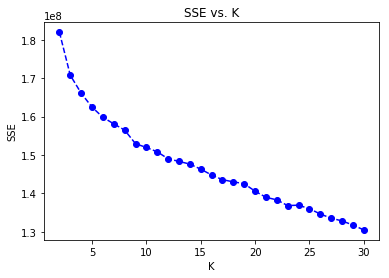

In [21]:
plot_kmeans_scores(centers, scores)

In [38]:
percentages = []
for idx, val in enumerate(scores):
    if len(scores) > idx + 1 :
        percentages.append( ((val - scores[idx+1]) / val) * 100)

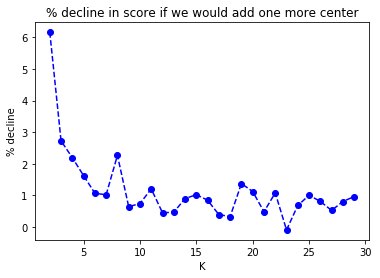

In [44]:
plt.plot(centers[:-1], percentages, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('% decline');
plt.title('% decline in score if we would add one more center');

In [16]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=9, n_jobs=-1)
model = kmeans.fit(x_pca)

In [17]:
pred = model.predict(x_pca)

In [73]:
# Save the predictions so that we don't have to run the kmeans algorithm to get the predictions
df = pd.DataFrame(pred)
df.columns = ['prediction']
df.to_csv("azdias_predictions.csv", header=None, sep=';', index=False)

### Discussion 3.1: Apply Clustering to General Population

Based on what is in the elbow chart it is not easy to choose a correct number of clusters. So I decided to make a plot that showed the decrease in SSE if we would add another center. Here you have something that looks like an elbow. Based on this graph I would choose n_clusters as 9, since the decline % is more or less the same from 9 clusters and up. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [53]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [54]:
customers.shape

(191652, 85)

In [56]:
# Due to the data in the customer set we have a different number of columns...
# This needs to be fixed manually
customers_data.shape

(191652, 241)

In [46]:
cus_col = list()
for col in customers_data.columns:
    cus_col.append(col)

azd_col = list()
for col in data.columns:
    azd_col.append(col)

# Print the difference in the two sets
print(list(set(azd_col) - set(cus_col)))

['GEBAEUDETYP_5.0']


In [60]:
# This means that we need to manually add this column, it should get the value 0, since it is nog present in the dataset
customers_data['GEBAEUDETYP_5.0'] = 0
# Now sort the columns in the same manner as the cleaned azdias dataframe. So we know for sure that the imputer and 
# scaler do the processes on the correct column
customers_data = customers_data[data.columns]

In [66]:
# Now we are ready to use the imputer again, using the same imputer object. This replaces NaN values with the median of azdias set!
imp_cus_data = pd.DataFrame(imp.transform(customers_data), columns=customers_data.columns)
# Scale the data with the same scaler
scaled_cus_data = pd.DataFrame(scaler.transform(imp_cus_data), columns=imp_cus_data.columns)
# Now do some dimensionality reduction, again with same object created earlier.
x_pca_cus = pca.transform(scaled_cus_data)

In [68]:
# Now we want to make the predictions
pred_cus = model.predict(x_pca_cus)

In [71]:
# Save the predictions so that we don't have to run the kmeans algorithm to get the predictions
df_cus = pd.DataFrame(pred_cus)
df_cus.columns = ['prediction']
df_cus.to_csv("customer_predictions.csv", header=None, sep=';', index=False)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [91]:
# Make a dataframe where we can easily show the distribution of the clusters as a percentage. 
cus_df = df_cus.groupby(['prediction']).size().reset_index(name='percentage')
cus_df['percentage'] = cus_df['percentage'] / len(df_cus) * 100
cus_df['type'] = 'Customer'

In [94]:
# Make a dataframe where we can easily show the distribution of the clusters as a percentage. 
azd_df = df.groupby(['prediction']).size().reset_index(name='percentage')
azd_df['percentage'] = azd_df['percentage'] / len(df) * 100
azd_df['type'] = 'General population'

In [96]:
# Union the dataframes so we can use catplot to show the percentage for both customers as well as azdias set.
prepped_df = cus_df.append(azd_df, ignore_index=True)

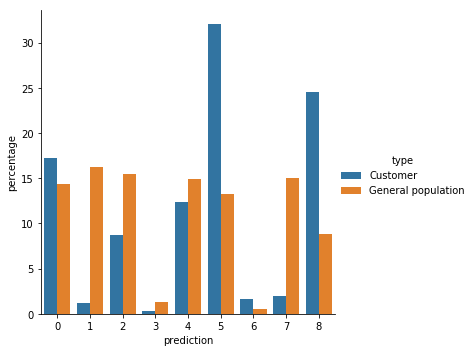

In [100]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.catplot(x='prediction', y='percentage', hue="type", data=prepped_df, kind="bar", legend=True)

In [158]:
# Train a randomforestclassifier on the azdias set, in this way we can get a grasp of what variables are important
randomForest = RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1)
randomForest.fit(scaled_data, pred)

# Get the importances per column 
importances = randomForest.feature_importances_

In [186]:
def feature_plot(importances, cols):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = cols.values[indices[:10]]
    values = importances[indices][:10]
    
    # Creat the plot
    fig = plt.figure(figsize = (20,10))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show() 

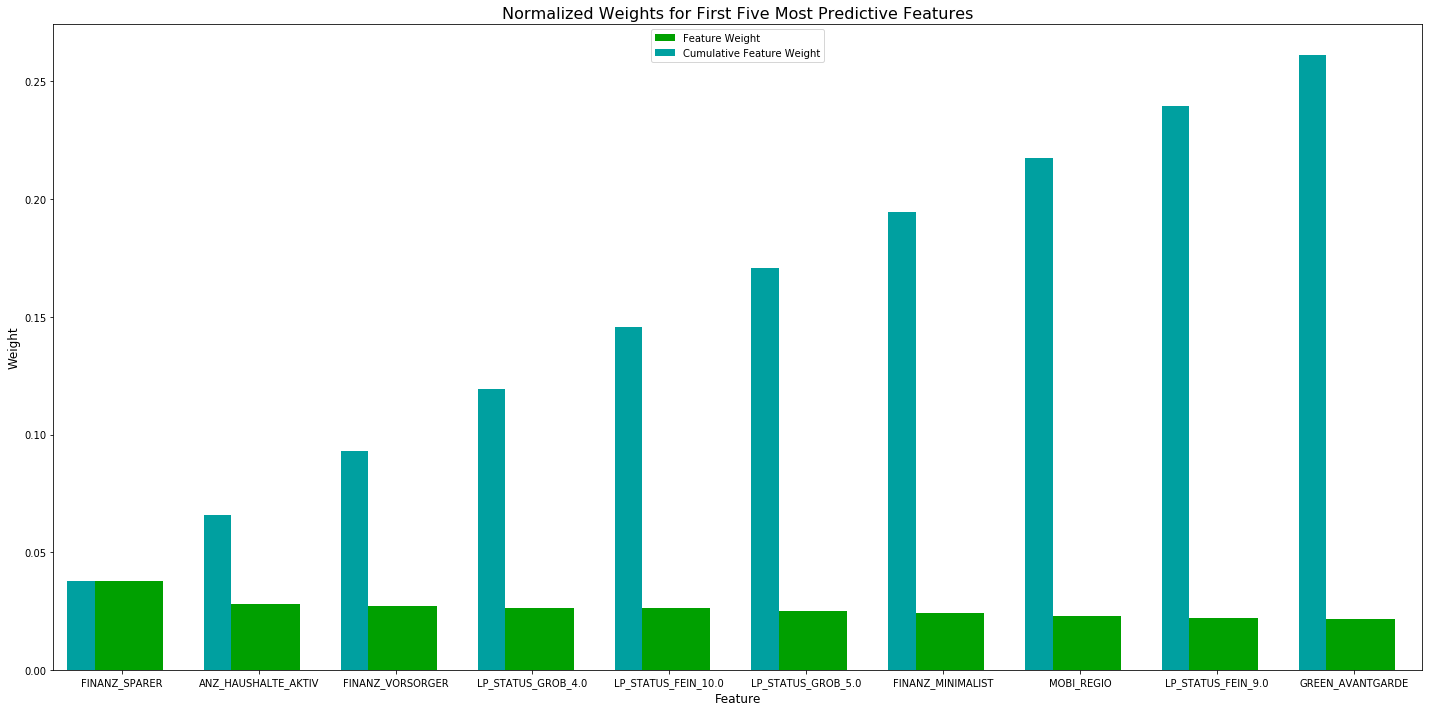

In [187]:
# make a plot to show the most important columns that determine to which cluster someone belongs to.
feature_plot(importances, scaled_data.columns)

In [138]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 5 is very overpresented in the customer data set.
# First get the center of this cluster, then inverse the pca, undo the scaling and put it into a dataframe.
clus5 = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[5,:]))[np.newaxis], columns=azd_col)

In [194]:
# Get the top 10 most important columns
indices = np.argsort(importances)[::-1]
columns = scaled_data.columns.values[indices[:10]]

In [207]:
for col in clus5.columns:
    # Rounding up to closest integer. # To make it easier to interpret, ignore columns with value = 0
    if col in columns:
        print("Column {}: {}".format(col, clus5.iloc[0][col]))
# Out of personal interest checking if gender matters. Don't see any reason to assume so.      
print("Column {}: {}".format('ANREDE_KZ', clus5.iloc[0]['ANREDE_KZ']))
# This describes someone who:
# has above average interest in finance
# saves above average money
# is not financially preparred
# was a member of green avantgarde as part of their youth
# lives in building that has 1 household per building, which is at least a family house.
# who is not very likely to move to another home (MOBI_REGIO 4 = low movement)
# belongs to the top earners

Column FINANZ_MINIMALIST: 4.477413282257805
Column FINANZ_SPARER: 1.8643362483336714
Column FINANZ_VORSORGER: 3.9896907190619295
Column GREEN_AVANTGARDE: 0.9808782555927712
Column ANZ_HAUSHALTE_AKTIV: 1.3420852144680504
Column MOBI_REGIO: 4.190217628410709
Column LP_STATUS_FEIN_10.0: 0.8495300359092961
Column LP_STATUS_FEIN_9.0: 0.006117584912456453
Column LP_STATUS_GROB_4.0: 0.012892990784555136
Column LP_STATUS_GROB_5.0: 0.8495300359092961
Column ANREDE_KZ: 1.4743234333720967


In [197]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster 1 is very underrepresented in the customer data set.
# First get the center of this cluster, then inverse the pca, undo the scaling and put it into a dataframe.
clus1 = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[1,:]))[np.newaxis], columns=azd_col)

In [206]:
for col in clus1.columns:
    # Rounding up to closest integer. # To make it easier to interpret, ignore columns with value = 0
    if col in columns:
        print("Column {}: {}".format(col, clus1.iloc[0][col]))
# Added the column LP_STATUS_GROB_1.0 to check to which social status that person belongs
print("Column {}: {}".format('LP_STATUS_GROB_1.0', clus1.iloc[0]['LP_STATUS_GROB_1.0']))
# Out of personal interest checking if gender matters. Don't see any reason to assume so.
print("Column {}: {}".format('ANREDE_KZ', clus1.iloc[0]['ANREDE_KZ']))
# This describes someone who:
# has very low interest in finance
# saves far below average money
# is financially preparred
# was not a member of green avantgarde as part of their youth
# lives in a building that has on average 15 household per building, which is most likely an appartment.
# who is very likely to move to another home (MOBI_REGIO 2 = high movement)
# belongs to the low-income earners        

Column FINANZ_MINIMALIST: 1.378972024780645
Column FINANZ_SPARER: 4.493528851105201
Column FINANZ_VORSORGER: 2.1021042427909404
Column GREEN_AVANTGARDE: 0.07081135716967091
Column ANZ_HAUSHALTE_AKTIV: 15.155177875550848
Column MOBI_REGIO: 1.7866200407783313
Column LP_STATUS_FEIN_10.0: 0.0014935909424562688
Column LP_STATUS_FEIN_9.0: 0.007972390392430612
Column LP_STATUS_GROB_4.0: 0.014460821464240159
Column LP_STATUS_GROB_5.0: 0.001493590942456241
Column LP_STATUS_GROB_1.0: 0.8966026854306115
Column ANREDE_KZ: 1.5732232403032684


### Discussion 3.3: Compare Customer Data to Demographics Data

First I made a plot to show the distribution of clusters for the customer dataset, compared to the azdias dataset. To do this in a fair way, I first had to calculate this to a percentage. Cluster 5 is very overrepresented in the customer dataset, compared to the azdias dataset. Cluster 1 is very underrepresented in the customer dataset. To get a grasp on which variables are important to what cluster someone belongs I trained a RandomForrestClassifier and used feature_importances_ to get the 10 most important features. 

Then I took the approach to take the cluster center and transform these cluster centers back to the features after cleaning the data. After transforming these center back, we can take a look at the value for the most important features based on the RandomForrestClassifier. I found the following interesting things.

The mail-order company is popular among people who are similar to the following profile, someone who:

- has above average interest in finance  
- saves above average money  
- is not financially prepared  (FINANZ_VORSORGER 4 = low financially prepared) But this does not fit with the rest...
- was a member of green avantgarde as part of their youth  
- lives in building that has 1 household per building, which is at least a family house  
- who is not very likely to move to another home (MOBI_REGIO 4 = low movement)  
- belongs to the top earners  

The mail-order company is unpopular among people who are similar to the following profile, someone who:

- has very low interest in finance  
- saves far below average money  
- is financially preparred (FINANZ_VORSORGER 2 = high financially prepared) But this does not fit with the rest...  
- was not a member of green avantgarde as part of their youth  
- lives in a building that has on average 15 household per building, which is most likely an appartment.  
- who is very likely to move to another home (MOBI_REGIO 2 = high movement)  
- belongs to the low-income earners    

In short, the company is popular among the the upper-class of the german society, but not very popular among the lower-class of german society. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.